In [11]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

try:
    from PIL import Image
except ImportError:
    import Image
import plotly.graph_objs as go
from PIL import Image
import plotly.express as px
def process_csv_files(at_filename, iperf_filename, ping_filename, coord_filename, distance_test):
    # Read the CSV files
    at_df = pd.read_csv(at_filename)
    iperf_df = pd.read_csv(iperf_filename)
    ping_df = pd.read_csv(ping_filename)
    coord_df = pd.read_csv(coord_filename)
    
    # Remove any rows with extreme values in the ping_df DataFrame
    ping_df = ping_df[ping_df['Latency'] < 70]
    

    # Filter rows in the at_df DataFrame based on specific criteria
    at_df = at_df[
        (at_df['PRX path RSRP value (dBm)'] > -140) & (at_df['PRX path RSRP value (dBm)'] < -44) &
        (at_df['DRX path RSRP value (dBm)'] > -140) & (at_df['DRX path RSRP value (dBm)'] < -44) &
        (at_df['RX2 path RSRP value (dBm)'] > -140) & (at_df['RX2 path RSRP value (dBm)'] < -44) &
        (at_df['RX3 path RSRP value (dBm)'] > -140) & (at_df['RX3 path RSRP value (dBm)'] < -44) &
        (at_df['PRX path RSRQ value (dB)'] > -21) & (at_df['PRX path RSRQ value (dB)'] < -3) &
        (at_df['DRC path RSRQ value (dB)'] > -21) & (at_df['DRC path RSRQ value (dB)'] < -3) &
        (at_df['RX2 path RSRQ value (dB)'] > -21) & (at_df['RX2 path RSRQ value (dB)'] < -3) &
        (at_df['RX3 path RSRQ value (dB)'] > -21) & (at_df['RX3 path RSRQ value (dB)'] < -3) &
        (at_df['PRX path SINR value (dB)'] > -23) & (at_df['PRX path SINR value (dB)'] < 40) &
        (at_df['DRX path SINR value (dB)'] > -23) & (at_df['DRX path SINR value (dB)'] < 40) &
        (at_df['RX2 path SINR value (dB)'] > -23) & (at_df['RX2 path SINR value (dB)'] < 40) &
        (at_df['RX3 path SINR value (dB)'] > -23) & (at_df['RX3 path SINR value (dB)'] < 40)
    ]

    # Calculate average values for each file
    ping_avg = ping_df.groupby('Measurement').mean()
    iperf_avg = iperf_df.groupby('measurement').mean()
    at_avg = at_df.groupby('Measurement').agg({'PRX path RSRP value (dBm)': 'mean','DRX path RSRP value (dBm)': 'mean','RX2 path RSRP value (dBm)': 'mean','RX3 path RSRP value (dBm)': 'mean','PRX path RSRQ value (dB)': 'mean','DRC path RSRQ value (dB)': 'mean','RX2 path RSRQ value (dB)': 'mean','RX3 path RSRQ value (dB)': 'mean','PRX path SINR value (dB)': 'mean','DRX path SINR value (dB)': 'mean','RX2 path SINR value (dB)': 'mean','RX3 path SINR value (dB)': 'mean', 'gNB_ID': 'first'})

    # Shift the coordinates 1 row down and place NaN in the first row
    coord_df = coord_df.shift(1) 
    coord_df.iloc[0] = np.nan

    # Convert bitrate from bits to Mbits in the iperf_avg DataFrame
    iperf_avg['bitrate'] = iperf_avg['bitrate'] / 1000000

    
    # Combine the dataframes into one, changes the names of the columns and round to 2 digits after the decimal point
    df = pd.concat([ping_avg, iperf_avg, at_avg, coord_df], axis=1)
    df = df.rename(columns={"Latency": "Latency (ms)", "bitrate": "Bitrate (Mbits)", "jitter": "Jitter (ms)"})
    df = df.round(2)
    
    # Create a new column for notes
    df['Note'] = ''

    # Add notes to specific rows
    df.loc[4, 'Note'] = 'This is was with the door open'
    df.loc[5, 'Note'] = 'This is was with the door closed'
    df.loc[8, 'Note'] = 'This is was with the door open'
    df.loc[20, 'Note'] = 'This is was with the door closed behind the thick glass of Tardis'
    df.loc[21, 'Note'] = 'This is was with the door open behind the thick glass of Tardis'
    df.loc[22, 'Note'] = 'This is was with the door open'
    df.loc[23, 'Note'] = 'This is was with the door closed'
    
    if distance_test:
        df2 = df.drop(df.index[:26])
        df2=df2.dropna(axis=0)
    else:
        df2 = df.drop(df.index[26:31])
        df2=df2.dropna(axis=0)
    return df2

In [12]:
def generate_floor_plan(at_filename, iperf_filename, ping_filename, coord_filename, image_file, distance_test = False ):
    # Process CSV files
    result_df = process_csv_files(at_filename, iperf_filename, ping_filename,coord_filename, distance_test)
    
    # Load the map image
    img = Image.open(image_file)

    # Get the size of the map image
    img_width, img_height = img.size

    # Select columns for hover information
    hover_cols = result_df.filter(items=["Note", "Latency (ms)", "Bitrate (Mbits)", "Jitter (ms)", "PRX path RSRP value (dBm)",
                                         "PRX path RSRQ value (dB)", "PRX path SINR value (dB)", "gNB_ID"]).iloc[0]

    # Create text for hover information
    hover_texts = []
    for _, row in result_df.iterrows():
        text = ""
        for col in hover_cols.index:
            text += f"{col}: {row[col]}<br>"
        hover_texts.append(text)

    # Create a scatter plot with the X and Y coordinates from the DataFrame
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=result_df["X-Coordinate"],
            y=result_df["Y-Coordinate"],
            mode="markers",
            marker=dict(
                size=5,
                symbol="circle",
                color="red"
            ),
            hovertext=hover_texts,
            hoverinfo="text"
        )
    )

    # Add the background image to the plot
    fig.update_layout(
        images=[go.layout.Image(
            source=img,
            xref="x",
            yref="y",
            x=0,
            y=img_height,
            sizex=img_width,  # set the size of the image in the x direction
            sizey=img_height,
            sizing="stretch",
            opacity=1,
            layer="below",
        )]
    )

    # Set the x and y axis ranges
    fig.update_xaxes(range=[0, 1280])
    fig.update_yaxes(range=[0, 720])

    # Show the interactive floor plan
    return fig


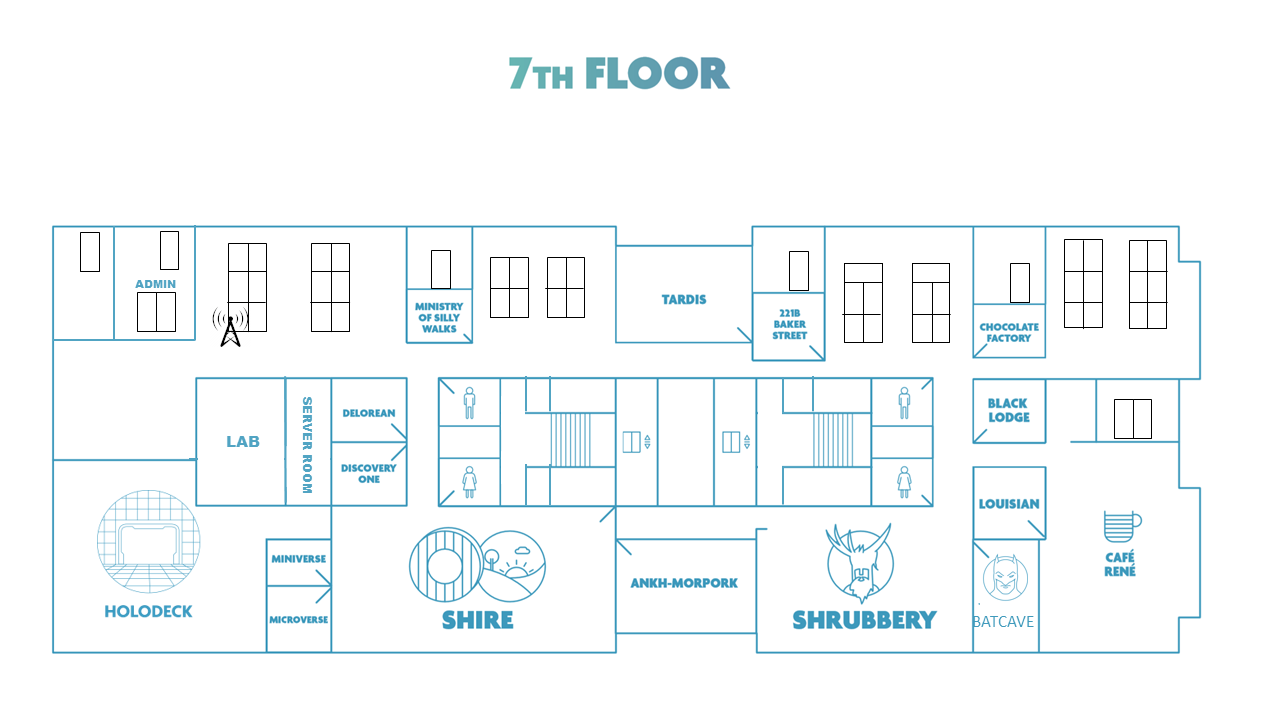

In [13]:
# Generate a floor plan plot based on CSV data
# Parameters:
# - 'AT_new_antenna.csv': CSV file containing AT (Access Terminal) data
# - 'totaliperf_new_antenna.csv': CSV file containing total IPERF data
# - 'ping_new_antenna.csv': CSV file containing ping data
# - 'coordinates.csv': CSV file containing coordinates data
# - 'Floorplan_beacon_1gnb_08_05.png': Path and name of the output floor plan plot image file
# - distance_test = True: A flag indicating that the distance test is being performed
floor_plan_plot = generate_floor_plan('AT_new_antenna.csv', 'totaliperf_new_antenna.csv', 'ping_new_antenna.csv',
                    'coordinates.csv', 'Floorplan_beacon_1gnb_08_05.png', distance_test = True)
floor_plan_plot.update_layout(title="5G Indoor Testing distance from 1 gNB")
floor_plan_plot.show()


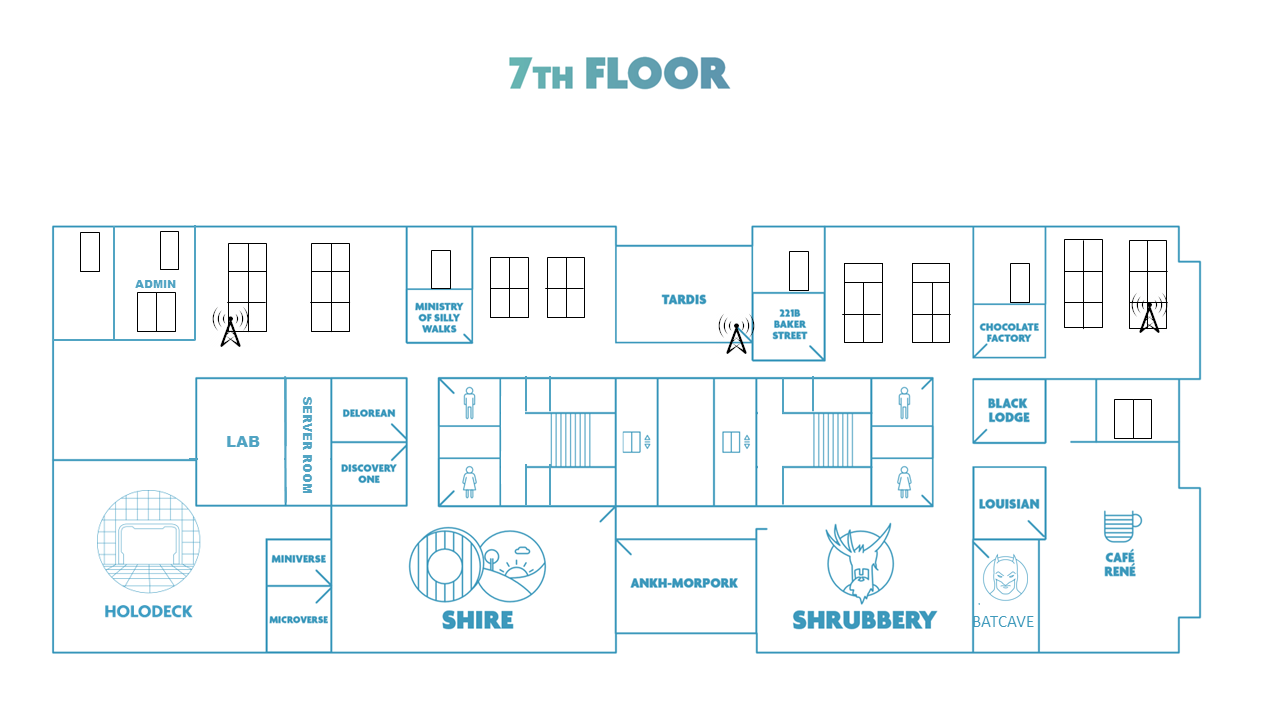

In [14]:
# Generate a floor plan plot based on CSV data
# Parameters:
# - 'AT_new_antenna.csv': CSV file containing AT (Access Terminal) data
# - 'totaliperf_new_antenna.csv': CSV file containing total IPERF data
# - 'ping_new_antenna.csv': CSV file containing ping data
# - 'coordinates.csv': CSV file containing coordinates data
# - 'Floorplan_beacon_1gnb_08_05.png': Path and name of the output floor plan plot image file
# - distance_test = True: A flag indicating that the distance test is being performed
floor_plan_plot = generate_floor_plan('AT_new_antenna.csv', 'totaliperf_new_antenna.csv', 'ping_new_antenna.csv',
                    'coordinates.csv', 'Floorplan_beacon_3gnb_08_05.png', distance_test = False)
floor_plan_plot.update_layout(
    title="5G Indoor Testing 3.5GHz Antenna with 3 gNB's",
    annotations=[
        dict(
            text="I encountered difficulties establishing a connection between Baker Street, the Chocolate Factory, and the interior of Cafe Rene.",
            xref="paper",
            yref="paper",
            x=0.5,
            y=1.05,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)
floor_plan_plot.show()


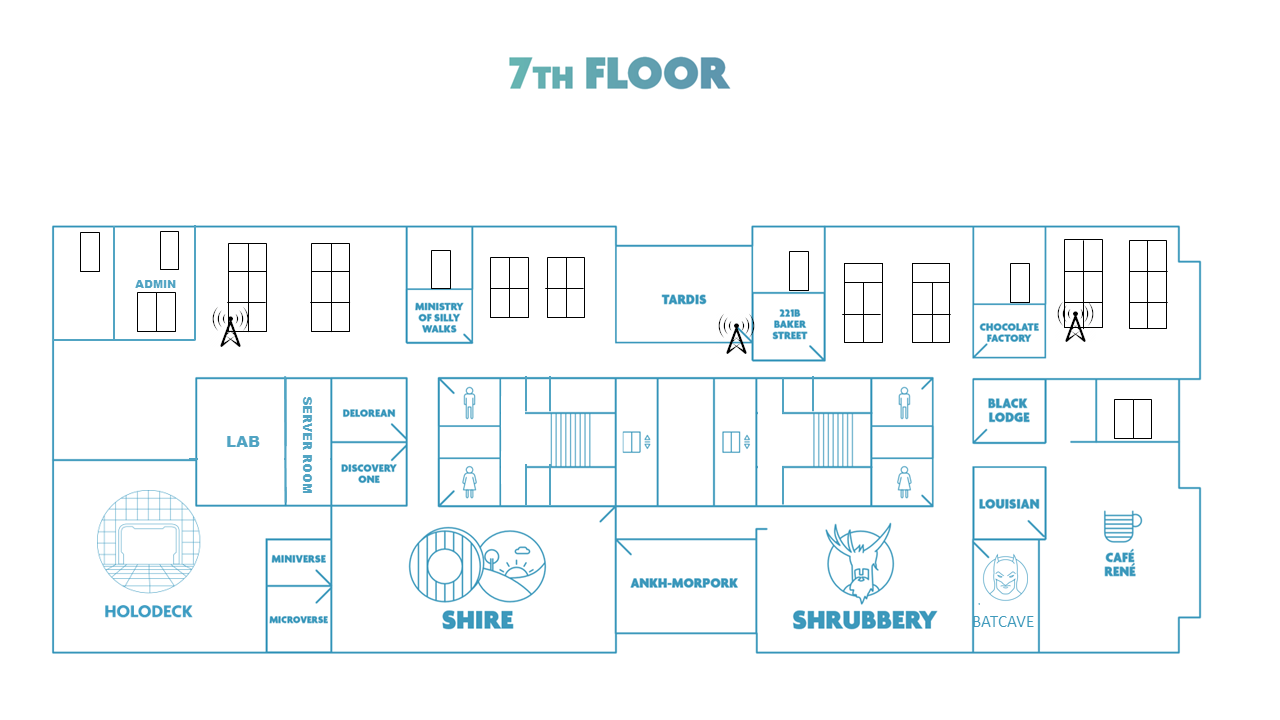

In [15]:
# Generate a floor plan plot based on CSV data
# Parameters:
# - 'AT_new_antenna.csv': CSV file containing AT (Access Terminal) data
# - 'totaliperf_new_antenna.csv': CSV file containing total IPERF data
# - 'ping_new_antenna.csv': CSV file containing ping data
# - 'coordinates.csv': CSV file containing coordinates data
# - 'Floorplan_beacon_1gnb_08_05.png': Path and name of the output floor plan plot image file
# - distance_test = True: A flag indicating that the distance test is being performed
floor_plan_plot = generate_floor_plan('at.csv', 'totaliperf.csv', 'ping.csv',
                    'coordinates.csv', 'Floorplan_beacon_3gnb_28_04.png', distance_test = False)
floor_plan_plot.update_layout(
    title="5G Indoor Testing 3.5GHz Antenna with 3 gNB's",
    annotations=[
        dict(
            text="I was unable to establish a connection between the Ministry of Silly Walks, the TARDIS, and the far end of Cafe Rene.",
            xref="paper",
            yref="paper",
            x=0.5,
            y=1.05,
            showarrow=False,
            font=dict(size=12)
        ),
        dict(
            text="It was also extremely difficult to establish a connection in the top right corner and just behind the Chocolate Factory (left).",
            xref="paper",
            yref="paper",
            x=0.5,
            y=1.0,
            showarrow=False,
            font=dict(size=12)
        )
    ]
)
floor_plan_plot.show()